# Problem description
Recently, we've got contacted by someone who wanted to compute a ensemble mean over outputs from different models of CMIP5. The problem is that he was looking at projections. This meant his dates were cftime objects are they are outside the range of dates possible for datetime64[ns] format. 

He was using monthly output from 2 models. Each model had a different calendar: 360_day and noLeap. And both models covered a slighly different period with overlap. This meant Xarray couldn't automatically align the dates and so we needed to find a manual solution.

The problem with the different calendars is that months don't have the same length in both of those. But since we are dealing with monthly data here and we don't do any weighted average by the length of a month, we don't care about anything more precise than the month. 

We decided we could then "cut" the precision of the date to the month and move all the dates to the same calendar.

Obviously, if you are dealing with daily or sub-daily data, you have a different problem. In that case, you don't have the same number of time steps per year or per month so you have to decide how you are going to get things to coincide.

# Imports

In [4]:
import xarray as xr
import cftime

In [8]:
!ls /g/data1b/al33/replicas/CMIP5/combined/BCC/bcc-csm1-1/rcp85/mon/atmos/Amon/r1i1p1/v20120705/pr

pr_Amon_bcc-csm1-1_rcp85_r1i1p1_200601-209912.nc
pr_Amon_bcc-csm1-1_rcp85_r1i1p1_210001-230012.nc


In [12]:
#HADGEM and BCC
filename=[ \
          '/g/data1b/al33/replicas/CMIP5/combined/MOHC/HadGEM2-ES/rcp85/mon/atmos/Amon/r1i1p1/v20130430/pr/'+'pr_Amon_HadGEM2-ES_rcp85_r1i1p1_227412-229911.nc', \
          '/g/data1b/al33/replicas/CMIP5/combined/BCC/bcc-csm1-1/rcp85/mon/atmos/Amon/r1i1p1/v20120705/pr/'+'pr_Amon_bcc-csm1-1_rcp85_r1i1p1_210001-230012.nc'   \
         ]

In [20]:
var_list = []
for ffile in filename:
    ds = xr.open_dataset(ffile)
    # Let's get the model name from the attributes to a coordinate as that will help with doing averages across the model
    # dimension. And then the model_id is kept when looking at the variable itself.
    ds = ds.assign_coords({'model_id':ds.model_id})
    var_list.append(ds['pr'])
var_list

[<xarray.DataArray 'pr' (time: 300, lat: 145, lon: 192)>
 [8352000 values with dtype=float32]
 Coordinates:
   * time      (time) object 2274-12-16 00:00:00 ... 2299-11-16 00:00:00
   * lat       (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
   * lon       (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
     model_id  <U10 'HadGEM2-ES'
 Attributes:
     standard_name:     precipitation_flux
     long_name:         Precipitation
     comment:           at surface; includes both liquid and solid phases from...
     units:             kg m-2 s-1
     original_name:     mo: m01s05i216
     history:           2011-11-24T09:57:29 out-of-bounds adjustments: (-1e-07...
     cell_methods:      time: mean
     cell_measures:     area: areacella
     associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...,
 <xarray.DataArray 'pr' (time: 2412, lat: 64, lon: 128)>
 [19759104 values with dtype=float32]
 Coordinates:
   * time      (time) ob

We can see those models are quite different. Different grids, different time periods. But there is an additional difference which isn't obvious with this printing and it is the calendars:

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 64, lon: 128, time: 2412)
Coordinates:
  * time       (time) object 2100-01-16 12:00:00 ... 2300-12-16 12:00:00
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
Attributes:
    institution:            Beijing Climate Center(BCC),China Meteorological ...
    institute_id:           BCC
    experiment_id:          rcp85
    source:                 bcc-csm1-1:atmosphere:  BCC_AGCM2.1 (T42L26); lan...
    model_id:               bcc-csm1-1
    forcing:                GHG Sl
    parent_experiment_id:   historical
    parent_experiment_rip:  r1i1p1
    branch_time:            2006.0
    contact:                Dr. Tongwen Wu (twwu

In [14]:
var_list[0].time

<xarray.DataArray 'time' (time: 300)>
array([cftime.Datetime360Day(2274, 12, 16, 0, 0, 0, 0, 6, 346),
       cftime.Datetime360Day(2275, 1, 16, 0, 0, 0, 0, 1, 16),
       cftime.Datetime360Day(2275, 2, 16, 0, 0, 0, 0, 3, 46), ...,
       cftime.Datetime360Day(2299, 9, 16, 0, 0, 0, 0, 5, 256),
       cftime.Datetime360Day(2299, 10, 16, 0, 0, 0, 0, 0, 286),
       cftime.Datetime360Day(2299, 11, 16, 0, 0, 0, 0, 2, 316)], dtype=object)
Coordinates:
  * time      (time) object 2274-12-16 00:00:00 ... 2299-11-16 00:00:00
    model_id  <U10 'HadGEM2-ES'
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

In [15]:
var_list[1].time

<xarray.DataArray 'time' (time: 2412)>
array([cftime.DatetimeNoLeap(2100, 1, 16, 12, 0, 0, 0, 1, 16),
       cftime.DatetimeNoLeap(2100, 2, 15, 0, 0, 0, 0, 3, 46),
       cftime.DatetimeNoLeap(2100, 3, 16, 12, 0, 0, 0, 4, 75), ...,
       cftime.DatetimeNoLeap(2300, 10, 16, 12, 0, 0, 0, 5, 289),
       cftime.DatetimeNoLeap(2300, 11, 16, 0, 0, 0, 0, 1, 320),
       cftime.DatetimeNoLeap(2300, 12, 16, 12, 0, 0, 0, 3, 350)], dtype=object)
Coordinates:
  * time      (time) object 2100-01-16 12:00:00 ... 2300-12-16 12:00:00
    model_id  <U10 'bcc-csm1-1'
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

Looking at the time coordinates we can see those aren't datetime64[ns] objects as it is usually the case for DataArray objects. This is because the dates are outside the time period that is possible to represent with datetime64[ns]. In that case, Xarray defaults to cftime objects. But then, the objects are different depending on the calendar used in the file. As you can see HadGEM2-ES is using a 360_day calendar while BCC_CSM1.1 is using a NoLeap calendar. 

Having 2 calendars means months don't have the same length in both models. In our case, it doesn't matter as we don't care for data at a finer scale than the month. We also don't want to weight the data in anyway by the length of the month. This also means we do not care for the day, hour etc. of the date. Whether the date is 2100/02/15 12:00:00 or 2100/02/27 00:00:00, both date would represent the same data.

We are not going to look at how to deal with the different grids (note the DataArray.interp() function could be useful here), but we need to deal with the dates to obtain a timeseries of model mean. To avoid the issue of the grids, we are going to look at the mean over a spatial domain:

In [21]:
for ii in range(len(var_list)):
    var_list[ii] = var_list[ii].sel(lat=[0., 90.],method='nearest').mean(dim=['lon','lat'])
print(var_list[0],'\n',var_list[1])

<xarray.DataArray 'pr' (time: 300)>
array([3.64325097e-05, 4.27831728e-05, 3.92413967e-05, 4.56348062e-05,
       6.77763601e-05, 7.60465846e-05, 5.75202830e-05, 3.32962081e-05,
       3.24944958e-05, 2.62415069e-05, 3.26726295e-05, 3.26325171e-05,
       3.14639801e-05, 3.01010750e-05, 1.83014763e-05, 2.17203506e-05,
       4.41498742e-05, 6.74383700e-05, 5.94772682e-05, 4.54635920e-05,
       4.01743928e-05, 2.49527602e-05, 1.79039071e-05, 3.73657967e-05,
       4.09420027e-05, 3.00161100e-05, 2.47476764e-05, 2.80293734e-05,
       5.12982551e-05, 6.39619902e-05, 7.37399969e-05, 5.08287230e-05,
       3.63605941e-05, 1.45873200e-05, 2.69833417e-05, 2.63794154e-05,
       3.28406932e-05, 5.15875618e-05, 4.20846372e-05, 4.35442489e-05,
       4.25339240e-05, 5.28369601e-05, 6.19484199e-05, 3.61547754e-05,
       2.46096697e-05, 2.87036473e-05, 3.83880979e-05, 2.82257261e-05,
       3.83581246e-05, 3.57428253e-05, 2.66543047e-05, 3.79485609e-05,
       4.66462188e-05, 4.64161421e-05, 6.

Finally, we can deal with the time coordinates. What we'll do is put all the dates on 1st of the month on a 360_day calendar. There is no automatic way to change from one calendar to another because the way you want to do it depends on why you are doing it. Here we are going to get the year and month for each date and put them as argument of the cftime.Datetime360Day() function which sets the date for the 360_day calendar.

In [25]:
def to_360day_monthly(da):
    '''Takes a DataArray. Change the 
    calendar to 360_day and precision to monthly.'''
    val = da.copy()
    time1 = da.time.copy()
    for itime in range(val.sizes['time']):
        bb = val.time.values[itime].timetuple()
        time1.values[itime] = cftime.Datetime360Day(bb[0],bb[1],1)

    # We rename the time dimension and coordinate to time360 to make it clear it isn't the original time coordinate.
    val = val.rename({'time':'time360'})
    time1 = time1.rename({'time':'time360'})
    val = val.assign_coords({'time360':time1})
    return val

In [31]:
ll = [to_360day_monthly(da) for da in var_list]
print(ll[0].time360)
print(ll[1].time360)

<xarray.DataArray 'time360' (time360: 300)>
array([cftime.Datetime360Day(2274, 12, 1, 0, 0, 0, 0, 5, 331),
       cftime.Datetime360Day(2275, 1, 1, 0, 0, 0, 0, 0, 1),
       cftime.Datetime360Day(2275, 2, 1, 0, 0, 0, 0, 2, 31), ...,
       cftime.Datetime360Day(2299, 9, 1, 0, 0, 0, 0, 4, 241),
       cftime.Datetime360Day(2299, 10, 1, 0, 0, 0, 0, 6, 271),
       cftime.Datetime360Day(2299, 11, 1, 0, 0, 0, 0, 1, 301)], dtype=object)
Coordinates:
  * time360   (time360) object 2274-12-01 00:00:00 ... 2299-11-01 00:00:00
    model_id  <U10 'HadGEM2-ES'
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time
<xarray.DataArray 'time360' (time360: 2412)>
array([cftime.Datetime360Day(2100, 1, 1, 0, 0, 0, 0, 0, 1),
       cftime.Datetime360Day(2100, 2, 1, 0, 0, 0, 0, 2, 31),
       cftime.Datetime360Day(2100, 3, 1, 0, 0, 0, 0, 4, 61), ...,
       cftime.Datetime360Day(2300, 10, 1, 0, 0, 0, 0, 2, 271),
       cftime.Datetime360Day(2300, 

Now we have the same calendar and all dates refer to the first of the month. Now we can concatenate the arrays together with xarray.concat() and xarray will align the arrays correctly. If the dates are different in anyway, Xarray would simply duplicate the times.

In [33]:
full_da = xr.concat(ll, 'model_id', join='outer')
full_da

<xarray.DataArray 'pr' (model_id: 2, time360: 2412)>
array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [2.7216340e-05, 2.1928223e-05, 2.5535373e-05, ..., 4.2512460e-05,
        4.3559990e-05, 4.7103615e-05]], dtype=float32)
Coordinates:
  * time360   (time360) object 2100-01-01 00:00:00 ... 2300-12-01 00:00:00
  * model_id  (model_id) object 'HadGEM2-ES' 'bcc-csm1-1'

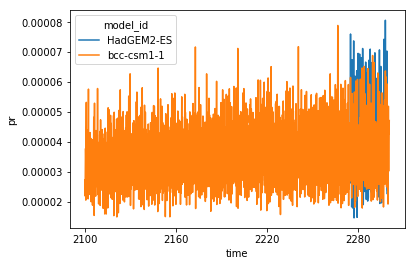

In [36]:
# When plotting the data, you can see the HadGEM2-ES data is correctly placed at the end of the timeseries.
%matplotlib inline
full_da.plot(hue='model_id')

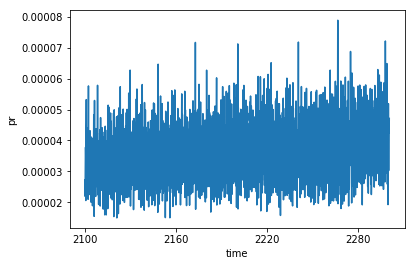

In [37]:
# Calculating the model mean is then trivial
full_da.mean(dim='model_id').plot()

Obviously, you may want to keep only the dates when you have data from all models. For this you simply change the `join` argument of concat:

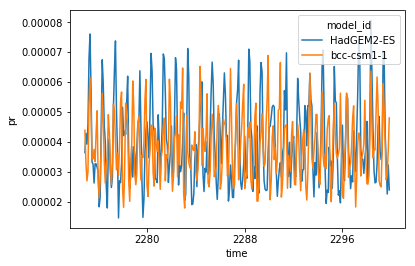

In [40]:
inter_da = xr.concat(ll,'model_id',join='inner')
inter_da.plot(hue='model_id')

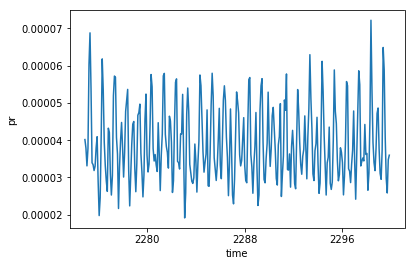

In [41]:
inter_da.mean(dim='model_id').plot()